This notebook contains step by step execution of the code, please follow it step by step and make sure to change directories according to your file structure.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import pdb

import matplotlib.pyplot as plt
import torchvision
import pandas as pd

from IPython.display import clear_output

In [2]:
!mkdir cars/
# Change dataset directory to your directory
!unzip -q /content/drive/MyDrive/Final_Project/datasets/resized_DVM_v2.zip -d /content/cars/

**Note: Please update all directories before use**

In [22]:
# Containing resized_DVM_v2.zip and dvm_image_table.csv files
dataset_dir = "/content/drive/MyDrive/Final_Project/capsgan_final/datasets"
# Where you want to store output
output_dir = "/content/drive/MyDrive/Final_Project/capsgan_final/output"
# Where you extracted resized_DVM_v2.zip
dataset_extract_dir = "/content/cars"
# Contains pretrained models, make sure "capsgan" and "dcgan" are subfolders containing actual models
pretrained_dir = "/content/drive/MyDrive/Final_Project/capsgan_final/models"

In [4]:
df1 = pd.read_csv("{}/dvm_image_table.csv".format(dataset_dir))

In [5]:
def get_loc(filename):
    filename = filename[' Image_name']
    dirs = filename.split('$$')
    final_path = dirs[0]+'/'+dirs[1]+'/'+dirs[2]+'/'+dirs[3]+'/'+filename
    return dataset_extract_dir+"/resized_DVM/" + final_path

# df1 = pd.read_csv("/content/drive/MyDrive/Final_Project/datasets/dvm_image_table.csv")
def get_angles(angle):
  df2 = pd.DataFrame(df1.loc[df1[' Predicted_viewpoint'] == angle][' Image_name'])
  df2['file_path'] = df2.apply(lambda x: get_loc(x), axis=1)
  df2=df2.reset_index()
  df2 = df2.drop(['index', ' Image_name'], axis=1)
  return df2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

# Utils

In [8]:
# Capsule Code
class ConvLayer(nn.Module):
  def __init__(self, in_channels=3, out_channels=256, kernel_size=9):
    super(ConvLayer, self).__init__()

    self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=kernel_size,
                            stride=1
                          )

  def forward(self, x):
    return F.relu(self.conv(x))

class PrimaryCaps(nn.Module):
  def __init__(self, size_of_capsule=8, in_channels=256, out_channels=32, kernel_size=9):
    super(PrimaryCaps, self).__init__()
    self.size_of_capsule=size_of_capsule
    self.out_channels = out_channels
    self.capsules = nn.ModuleList([
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0) 
                      for _ in range(size_of_capsule)])
  
  def forward(self, x):
    u = [capsule(x) for capsule in self.capsules]
    num_of_capsules = u[1].shape[-1] * u[1].shape[-1] * self.out_channels
    # print(u[1].shape, u[1].shape[-1], num_of_capsules, self.size_of_capsule)
    u = torch.stack(u, dim=1)
    # print(u.shape)
    u = u.view(x.size(0), num_of_capsules, self.size_of_capsule)
    return self.squash(u)
  
  def squash(self, input_tensor):
    squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
    output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
    return output_tensor

class DigitCaps(nn.Module):
  def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16, use_cuda=False):
    super(DigitCaps, self).__init__()

    self.in_channels = in_channels
    self.num_routes = num_routes
    self.num_capsules = num_capsules
    self.use_cuda = use_cuda

    self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

  def forward(self, x):
    batch_size = x.size(0)
    x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

    W = torch.cat([self.W] * batch_size, dim=0)
    u_hat = torch.matmul(W, x)

    b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1)).to(device)

    num_iterations = 3
    for iteration in range(num_iterations):
        c_ij = F.softmax(b_ij)
        c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4).to(device)
        s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
        v_j = self.squash(s_j)
        
        if iteration < num_iterations - 1:
            a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
            b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

    return v_j.squeeze(1)

  def squash(self, input_tensor):
    squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
    output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
    return output_tensor


class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    
    self.reconstraction_layers = nn.Sequential(
        nn.Linear(16 * 10, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 784),
        nn.Sigmoid()
    )
      
  def forward(self, x, data):
    classes = torch.sqrt((x ** 2).sum(2))
    classes = F.softmax(classes)
    
    _, max_length_indices = classes.max(dim=1)
    masked = Variable(torch.sparse.torch.eye(10)).to(device)
    masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
    
    reconstructions = self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
    reconstructions = reconstructions.view(-1, 1, 28, 28)
    
    return reconstructions, masked


def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1., 0.02)
        m.bias.data.fill_(0.)

# CapsGAN (Discriminator / Generator) Code

In [9]:
# Capsnet Discriminator
class CapsNet_Discriminator(nn.Module):
  def __init__(self):
    super(CapsNet_Discriminator, self).__init__()
    self.conv_layer1 = ConvLayer(in_channels=3, out_channels=256)
    self.conv_layer2 = ConvLayer(in_channels=256, out_channels=512)
    self.primary_capsules = PrimaryCaps(size_of_capsule=16, in_channels=512, out_channels=32)
    self.prediction_capsule = DigitCaps(num_capsules=1, num_routes=20*20*32, in_channels=16)
    self.decoder = Decoder()
    self.mse_loss = nn.MSELoss()
      
  def forward(self, data): #we dont want reconstruction enforcement for now

    #predicts probability of one output
    x = self.conv_layer1(data)
    # print("x1:", x.shape)
    x = self.conv_layer2(x)
    # print("x2:", x.shape)
    x = self.primary_capsules(x)
    # print("x3:", x.shape)
    x = self.prediction_capsule(x)
    # print("x4:", x.shape)
    output = x
    reconstructions, masked = self.decoder(output, data) 
    return output
  
  def loss(self, data, x, target, reconstructions=False):
    return self.margin_loss(x, target) #+ self.reconstruction_loss(data, reconstructions)
  
  def margin_loss(self, x, labels, size_average=True):
    batch_size = x.size(0)

    v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

    left = F.relu(0.9 - v_c).view(batch_size, -1)
    right = F.relu(v_c - 0.1).view(batch_size, -1)

    loss = labels * left + 0.5 * (1.0 - labels) * right
    loss = loss.sum(dim=1).mean()

    return loss
  
  def reconstruction_loss(self, data, reconstructions):
    loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
    return loss * 0.0005

# DC Generator with digitcaps input
class CapsNet_Generator(nn.Module):
  def __init__(self):
    super(CapsNet_Generator, self).__init__()
    # self.convs = nn.ModuleList()
    in_channels = 100
    in_dim = 8 * 8 * 128
    self.lin1 = nn.Linear(100 * 16, in_dim)
    self.bn1 = nn.BatchNorm2d(128)
    self.leakyrelu = nn.LeakyReLU()
    # self.lin2 = nn.Linear(6272, 6272)
    # self.bn2 = nn.BatchNorm2d(6272)
    self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=7, stride=1, padding=0, bias=False)
    self.bn3 = nn.BatchNorm2d(128)
    self.relu = nn.ReLU()
    self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=0, bias=False)
    self.bn4 = nn.BatchNorm2d(64)
    # self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0, bias=False)
    # self.bn5 = nn.BatchNorm2d(32)
    self.convt4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=6, stride=2, padding=0, bias=False)
    # self.bn6 = nn.BatchNorm2d(16)
    # self.convt5 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)

    self.tanh = nn.Tanh()
    self.apply(init_weight)

  def forward(self, input, dig_caps):
    # print(input.shape, dig_caps.shape)
    out = input * dig_caps
    # print("out0:", out.shape)
    out = out.view(out.size(0), -1)
    # print("out1: ",out.shape)

    out = self.lin1(out)
    # print("lin1: ",out.shape)

    out = out.reshape(-1,128, 8, 8)
    # print("reshape1: ",out.shape)

    out = self.bn1(out)
    # print("bn1: ",out.shape)

    out = self.leakyrelu(out)
    # print("lr1: ",out.shape)

    # out = self.lin2(out)
    # print("lin2: ",out.shape)

    # out = self.bn2(out)
    # print("bn2: ",out.shape)

    # out = self.leakyrelu(out)
    # print("lr2: ",out.shape)

    out = self.relu(self.bn3(self.convt1(out)))
    # print("convt1: ",out.shape)

    out = self.relu(self.bn4(self.convt2(out)))
    # print("convt2: ",out.shape)
    # out = self.relu(self.bn5(self.convt3(out)))
    # print("convt3: ",out.shape)
    # out = self.relu(self.bn6(self.convt4(out)))
    # print("convt4: ",out.shape)

    out = self.tanh(self.convt4(out))
    # print("out:", out.shape)

    return out
    

# DCGAN (Discriminator / Generator) Code

In [10]:
# DC Discriminator
class DCDiscriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(DCDiscriminator, self).__init__()
    self.disc = nn.Sequential(
        #input : N x channel_img x 64 x 64
        nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride=2, padding=1
        ), # 32x32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4,2,1), # 16x16
        self._block(features_d*2, features_d*4, 4,2,1), # 8x8
        self._block(features_d*4, features_d*8, 4,2,1), # 4x4
        nn.Conv2d(features_d*8, 1, 4,2,0), # 1x1
        nn.Sigmoid()
    )

  def _block(self, in_channels, out_channels, kernal_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernal_size,
            stride,
            padding,
            bias=False
        ),
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self, x):
    return self.disc(x)

#DC Generator
class DCGenerator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(DCGenerator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            # self._block(features_g * 2 , features_g , 4, 2, 1),  # img: 64x64
            # self._block(features_g , 3, 4, 2, 1),  # img: 128x128
            # nn.Conv2d(3,6,4,2,1), #img 64x64x6
            # nn.BatchNorm2d(6),
            # nn.ReLU(0.2),
            # nn.Conv2d(in_channels=6, out_channels=3, kernel_size=1, stride=1, padding=0, bias= False),
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        for layer in self.net:
            x = layer(x)
            # print(x.size())
        return x
        # return self.net(x)

# Loading Data


In [12]:
# Available Car Angles : 0, 45, 180, 90
car_angle = 0


file_path_df = get_angles(car_angle)

IMAGE_SIZE = 64
CHANNELS_IMG = 3
BATCH_SIZE = 128
EPOCHS = 15
Z_DIM = 256

transforms_ = transforms.Compose(
    [
      transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
      transforms.ToTensor(),
      transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)],
        [0.5 for _ in range(CHANNELS_IMG)]
      )
    ]
)
import torch
import torchvision
from PIL import Image


class CarDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        return self.transform(Image.open(row["file_path"]))
        

dataset = CarDataset(file_path_df, transform=transforms_)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

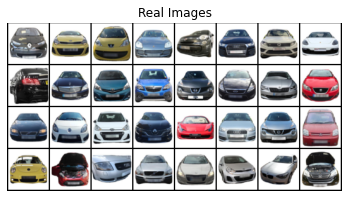

In [13]:
# Real Images
for i, (x) in enumerate(loader):
  if(i==0):
    img_grid_fake = torchvision.utils.make_grid(
        x[:32], normalize=True
    )
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(img_grid_fake.to('cpu').permute(1, 2, 0))
    plt.show()
  else:
    break

# Getting Models Ready

In [14]:
# CapsGAN
caps_discriminator = CapsNet_Discriminator().to(device)
caps_generator = CapsNet_Generator().to(device)

#DCGAN
dc_features = 64
dc_discriminator = DCDiscriminator(CHANNELS_IMG, dc_features).to(device)
dc_generator = DCGenerator(Z_DIM, CHANNELS_IMG, dc_features).to(device)

In [15]:
torch.cuda.empty_cache()

# Train From Scratch (CapsuleGAN)

In [23]:
caps_discriminator.train()
caps_generator.train()

CapsNet_Generator(
  (lin1): Linear(in_features=1600, out_features=8192, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (convt1): ConvTranspose2d(128, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (convt2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt4): ConvTranspose2d(64, 3, kernel_size=(6, 6), stride=(2, 2), bias=False)
  (tanh): Tanh()
)

In [16]:
optimizer_d_caps = optim.Adam(caps_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g_caps = optim.Adam(caps_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

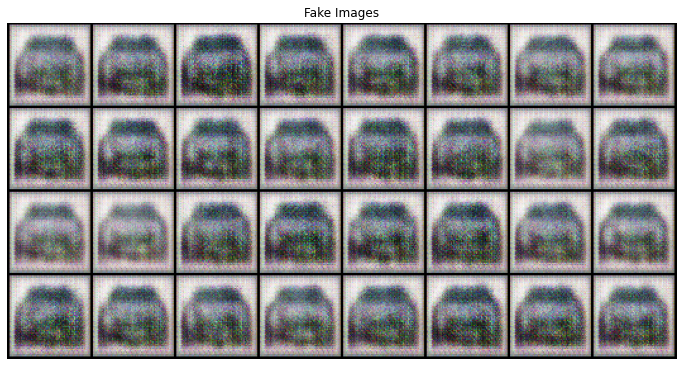

Epochs:[00/02], Steps:[002/1879], errD: 80.4373, errG: 105.4261


KeyboardInterrupt: ignored

In [21]:
real_label, fake_label = 1, 0
EPOCHS = 2
Z_DIM = 100
for epoch in range(EPOCHS):
  for i, (x) in enumerate(loader):
      batch_size = x.size(0)

      optimizer_d_caps.zero_grad()
      x = Variable(x).to(device)

      output = caps_discriminator(x)
      real_v = Variable(torch.Tensor(batch_size).fill_(real_label).float()).to(device)
      loss_d = caps_discriminator.loss(x, output, real_v,False)
      loss_d.backward()

      z = torch.randn((batch_size, Z_DIM, 1 ,1)).to(device)
      fake = caps_generator(z, output.detach())
      output = caps_discriminator(fake.detach())
      fake_v = Variable(torch.Tensor(batch_size).fill_(fake_label).float()).to(device)
      loss_g = caps_discriminator.loss(x,output, fake_v, False)
      loss_g.backward()
      optimizer_d_caps.step()
      err_D = loss_d + loss_g

      # training G
      optimizer_g_caps.zero_grad()
      output = caps_discriminator(fake)
      real_v = Variable(torch.Tensor(batch_size).fill_(real_label).float()).to(device)
      loss = caps_discriminator.loss(x,output, real_v)
      loss.backward()
      optimizer_g_caps.step()
      err_G = loss

      if(i % 1 == 0):
        clear_output(wait=True)
        img_grid_fake = torchvision.utils.make_grid(
            fake[:32], normalize=True
        )
        plt.figure(figsize = (12,12))
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(img_grid_fake.to('cpu').permute(1, 2, 0))
        # if(i % 5 == 0):
        #   plt.savefig("{}/capsgan/{}/epoch{}_step{}.png".format(output_dir, car_angle, epoch, i), transparent=True)
        plt.show()
        print('Epochs:[{:02d}/{:02d}], Steps:[{:03d}/{:03d}], errD: {:.4f}, errG: {:.4f}'.format(
              epoch, EPOCHS, i, len(loader), err_D, err_G))
        img_grid_real = torchvision.utils.make_grid(
            x[:32], normalize=True
        )

# Train From Scratch (DCGAN)

In [24]:
dc_discriminator.train()
dc_generator.train()

DCGenerator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3

In [25]:
optimizer_d_dc = optim.Adam(dc_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g_dc = optim.Adam(dc_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

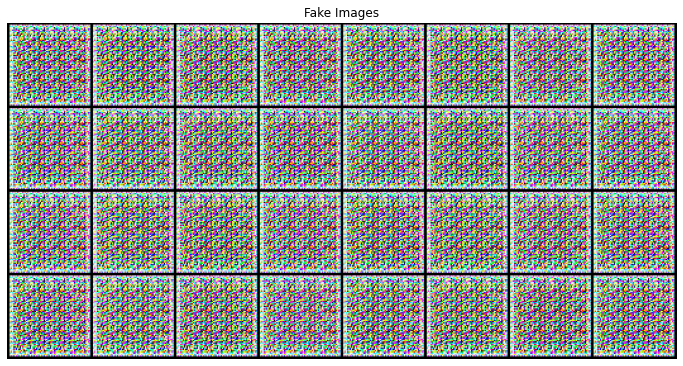

Epoch:[00/03], Steps:[030/1879], errD: 0.3665, errG: 14.3091


KeyboardInterrupt: ignored

In [26]:
from IPython.display import clear_output
EPOCHS = 3
Z_DIM = 256
for epoch in range(EPOCHS):
  for i, (x) in enumerate(loader):
      batch_size = x.size(0)

      optimizer_d_dc.zero_grad()
      x = Variable(x).to(device)
      output = dc_discriminator(x)

      real_v = torch.ones_like(output).to(device)
      loss_d = criterion(output, real_v)
      loss_d.backward()

      z = torch.randn((batch_size, Z_DIM, 1 ,1)).to(device)
      fake = dc_generator(z)
      output = dc_discriminator(fake.detach())
      fake_v = torch.zeros_like(output).to(device)
      loss_g = criterion(output, fake_v)
      loss_g.backward()
      optimizer_d_dc.step()
      err_D = loss_d + loss_g

      # training G
      optimizer_g_dc.zero_grad()
      output = dc_discriminator(fake)
      real_v = torch.ones_like(output).to(device)
      loss = criterion(output, real_v)
      loss.backward()
      optimizer_g_dc.step()
      err_G = loss

      if(i % 10 == 0):
        clear_output(wait=True)
        img_grid_fake = torchvision.utils.make_grid(
            fake[:32], normalize=True
        )
        plt.figure(figsize = (12,12))
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(img_grid_fake.to('cpu').permute(1, 2, 0))
        # if(i % 10 == 0):
        #   plt.savefig("{}/dcgan/{}/epoch{}_step{}.png".format(output_dir, car_angle, epoch, i), transparent=True)
        plt.show()
        print('Epoch:[{:02d}/{:02d}], Steps:[{:03d}/{:03d}], errD: {:.4f}, errG: {:.4f}'.format(
              epoch, EPOCHS, i, len(loader), err_D, err_G))

        img_grid_real = torchvision.utils.make_grid(
            x[:32], normalize=True
        )

# Loading Pretrained Models

In [14]:
# Loading Weights
# CapsGan
caps_discriminator.load_state_dict(torch.load("{}/capsgan/capsgan_cars_full_64_disc_{}_1".format(pretrained_dir, car_angle)))
caps_generator.load_state_dict(torch.load("{}/capsgan/capsgan_cars_full_64_gen_{}_1".format(pretrained_dir, car_angle)))

# DCGan
dc_generator.load_state_dict(torch.load("{}/dcgan/dcgan_cars_full_64_gen_{}_2".format(pretrained_dir, car_angle)))

<All keys matched successfully>

# Generate Images (Model Evaluation)

In [15]:
fixed_noise = torch.randn((x.size(0), Z_DIM, 1 ,1))
fixed_noise = Variable(fixed_noise).to(device)

In [16]:
fixed_noise_caps = torch.randn((x.size(0), 100, 1 ,1))
fixed_noise_caps = Variable(fixed_noise_caps).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([128, 1, 16, 1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


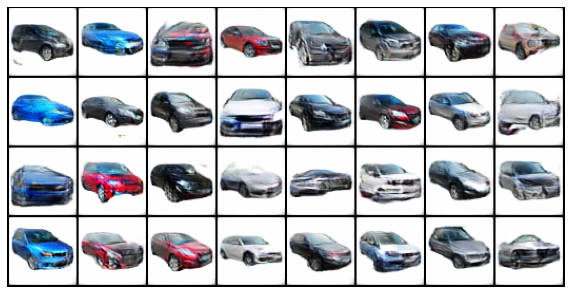

In [17]:
#CapsGAN
# from torchviz import make_dot

fixed_noise_caps = torch.randn((x.size(0), 100, 1 ,1))
fixed_noise_caps = Variable(fixed_noise_caps).to(device)
for i, (x) in enumerate(loader):
  if(i==0):
    real_images = x
    with torch.no_grad():
      output = caps_discriminator(x.to(device))
      print(output.shape)
      # output = torch.randn()
      fake_caps = caps_generator(fixed_noise_caps, output)
      img_grid_fake = torchvision.utils.make_grid(
          fake_caps[:32], normalize=True
      )
      plt.figure(figsize = (10,10))
      plt.axis("off")
      plt.imshow(img_grid_fake.to('cpu').permute(1, 2, 0))
      plt.show()
    
    break

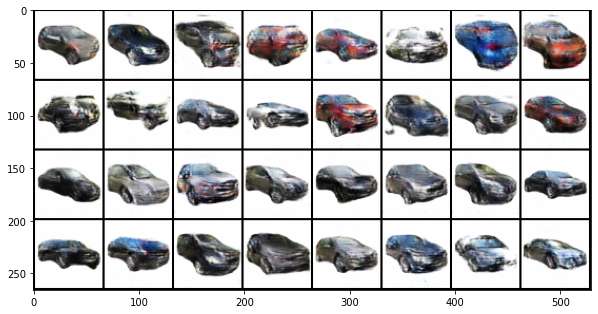

In [18]:
# DCGan
fake_dcgan = dc_generator(fixed_noise)
img_grid_fake = torchvision.utils.make_grid(
    fake_dcgan[:32], normalize=True
)
plt.figure(figsize = (10,10))
plt.imshow(img_grid_fake.to('cpu').permute(1, 2, 0))
plt.show()

In [19]:
fake_caps.shape, fake_dcgan.shape, real_images.shape

(torch.Size([128, 3, 64, 64]),
 torch.Size([128, 3, 64, 64]),
 torch.Size([128, 3, 64, 64]))

# Compare Results

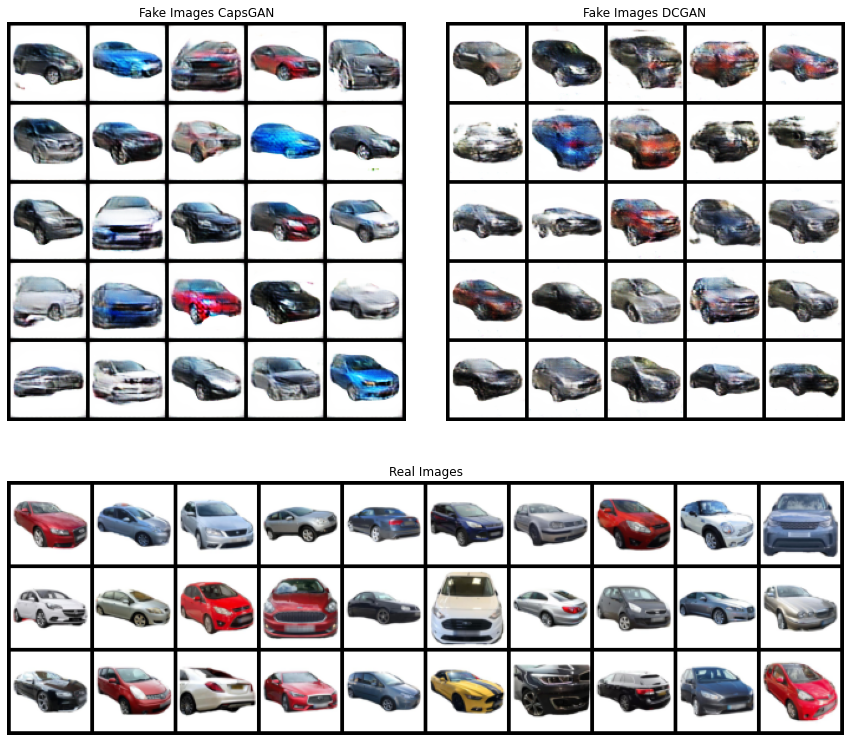

In [27]:
import numpy as np

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_images.to(device)[:30],nrow=10, padding=3, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(2,2,1)
plt.margins(0.05)
plt.axis("off")
plt.title("Fake Images CapsGAN")
plt.imshow(np.transpose(vutils.make_grid(fake_caps.to(device)[:25],nrow=5, padding=3, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(2,2,2)
plt.margins(0.05)
plt.axis("off")
plt.title("Fake Images DCGAN")
plt.imshow(np.transpose(vutils.make_grid(fake_dcgan.to(device)[:25],nrow=5, padding=3, normalize=True).cpu(),(1,2,0)))
plt.subplots_adjust(wspace=0.1, hspace=-0.1)

plt.savefig("/content/drive/MyDrive/Final_Project/capsgan_final/outputs/car_angle_{}.png".format(car_angle), transparent=True,bbox_inches = 'tight',pad_inches = 0)

plt.show()

# Convert Images to shape : (3, 299, 299)

In [21]:
resize = transforms.Resize(299)
fake_caps_resize = resize(fake_caps)
fake_dcgan_resize = resize(fake_dcgan)
real_images_resize = resize(real_images)

In [22]:
fake_caps_resize.shape, fake_dcgan_resize.shape, real_images_resize.shape

(torch.Size([128, 3, 299, 299]),
 torch.Size([128, 3, 299, 299]),
 torch.Size([128, 3, 299, 299]))

# FID Measurement

In [23]:
# !pip install pytorch-ignite
# !pip install pytorch_fid

In [24]:
from pytorch_fid.inception import InceptionV3
from ignite.metrics.gan import FID

device = "cpu"
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

import torch.nn as nn
import tqdm

class WrapperInceptionV3(nn.Module):
    
    def __init__(self, fid_incv3):
        super().__init__()
        self.fid_incv3 = fid_incv3
    
    @torch.no_grad()
    def forward(self, x):
        y = self.fid_incv3(x)
        y = y[0]
        y = y[:, :, 0, 0]
        return y

def calculate_FID(fake, real):
  wrapper_model = WrapperInceptionV3(model)
  wrapper_model.eval();

  m = FID(num_features=dims, feature_extractor=wrapper_model)
  torch.manual_seed(0)
  y_pred, y = fake, real
  for i in tqdm.tqdm(range(len(y_pred))):
      # torchvision.utils.save_image(y_pred[i], f'pred/{i}.png')
      # torchvision.utils.save_image(y[i], f'gt/{i}.png')
      m.update((y_pred[i:i+1], y[i:i+1]))

  return m.compute()  # 6.109078042628951

In [25]:
caps_fid = calculate_FID(fake_caps_resize[0:25], real_images_resize[0:25])
dcgan_fid = calculate_FID(fake_dcgan_resize[0:25], real_images_resize[0:25])

100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


In [26]:
print("FID Score for CapsuleGan with cars facing angle of {} degree : {}".format(car_angle, caps_fid))
print("FID Score for DCGan with cars facing angle of {} degree : {}".format(car_angle, dcgan_fid))

FID Score for CapsuleGan with cars facing angle of 45 degree : 233.9054805008494
FID Score for DCGan with cars facing angle of 45 degree : 322.43786957891126
